In [2]:
# Import necessary packages
import contextily as ctx
import folium
import geopy.distance
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from operator import itemgetter
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
import random

In [3]:
# Specify the center location (latitude, longtitude)
# Zona Titan
CENTER_LOCATION = (44.413162, 26.163739)

#HQ Courier
HQ_COURIER = (44.387820, 26.168503)

# Specify distance in meters
DIST = 3000

# Specify the number of vehicles
NUM_VEHICLES = 4

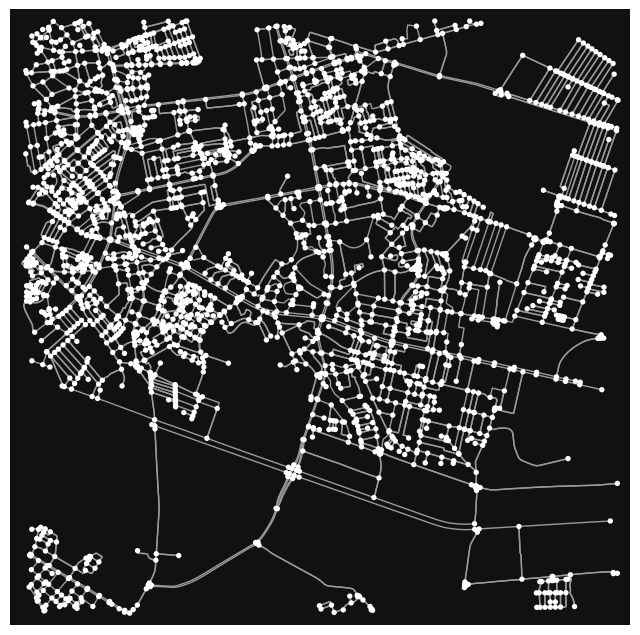

In [4]:
# Get the highway graph
G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
*_, = ox.plot_graph(G)

MultiDiGraph with 2508 nodes and 6016 edges


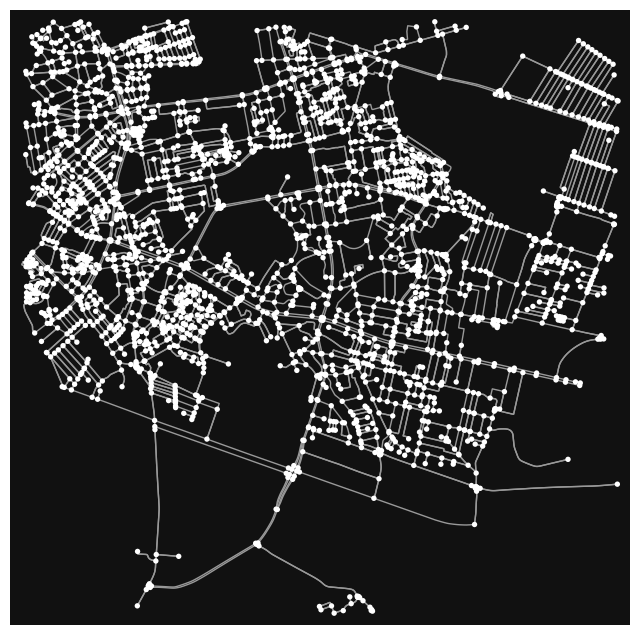

In [5]:
# Remove unreachable nodes from the graph
G = ox.utils_graph.get_largest_component(G, strongly=True)
print(G)
*_, = ox.plot_graph(G)

In [6]:
# Use the nearest node to the center location as the depot
HQ_COURIER = (44.387820, 26.168503)
hq = ox.distance.nearest_nodes(G, HQ_COURIER[1], HQ_COURIER[0])
hq

6529858706

In [7]:
def findBestWayForCourier(G, courier_destinations, hq) :
  # Create a directed graph for path finding
  directed_G = G.to_directed()

  # Create a list to store the nodes in the path
  path_nodes = []

  # Start from HQ_COURIER
  current_location = ox.distance.nearest_nodes(directed_G, hq[1], hq[0])

  # Add HQ_COURIER to the path
  path_nodes.append(current_location)

  # Iterate through the randomly selected edges
  for edge in courier_destinations:
      # Get the target node of the edge
      target_node = edge[1]

      # Find the shortest path from the current location to the target node
      shortest_path = nx.shortest_path(directed_G, source=current_location, target=target_node, weight='length')

      # Add the nodes in the path to the overall path_nodes list
      path_nodes.extend(shortest_path[1:])  # Exclude the starting node as it's already added

      # Update the current location to the target node for the next iteration
      current_location = target_node

  # Find the shortest path back to HQ_COURIER
  shortest_path_back = nx.shortest_path(directed_G, source=current_location, target=path_nodes[0], weight='length')

  # Add the nodes in the return path to the overall path_nodes list
  path_nodes.extend(shortest_path_back[1:])
  return path_nodes

<ipython-input-11-dc788b40af6b>:35: UserWarning: color argument of Icon should be one of: {'red', 'orange', 'green', 'darkblue', 'lightgreen', 'white', 'lightgray', 'beige', 'lightred', 'black', 'lightblue', 'blue', 'cadetblue', 'darkgreen', 'purple', 'darkred', 'pink', 'darkpurple', 'gray'}.
  icon=folium.Icon(color=colors[i], icon='circle', prefix='fa')


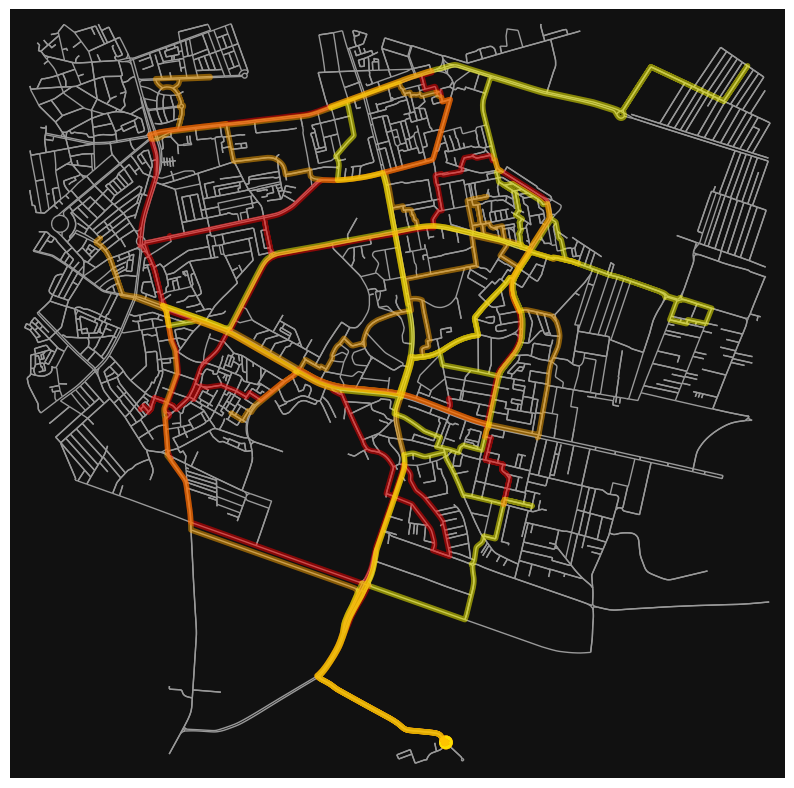

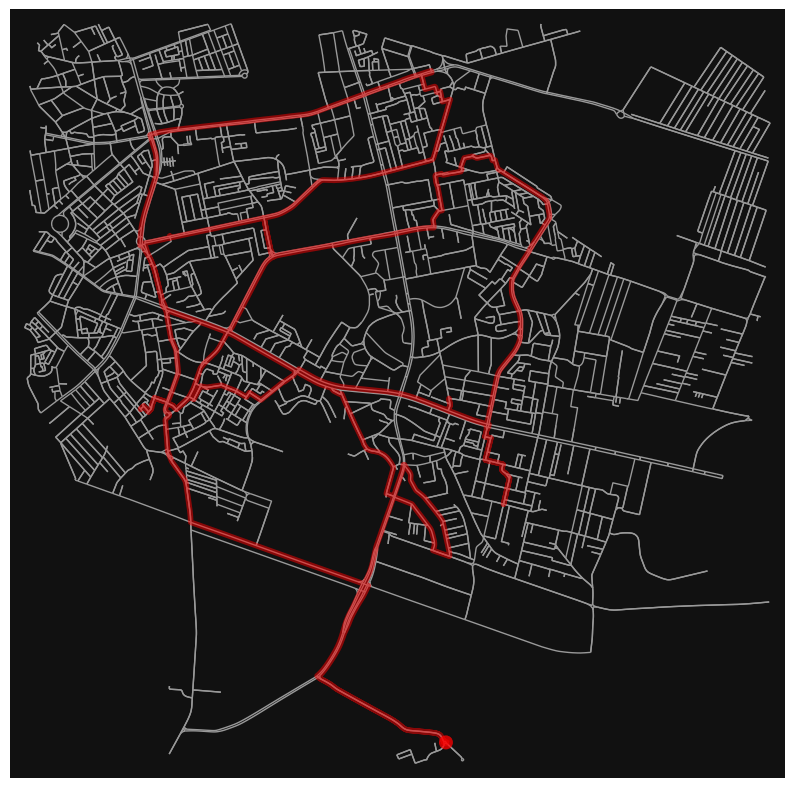

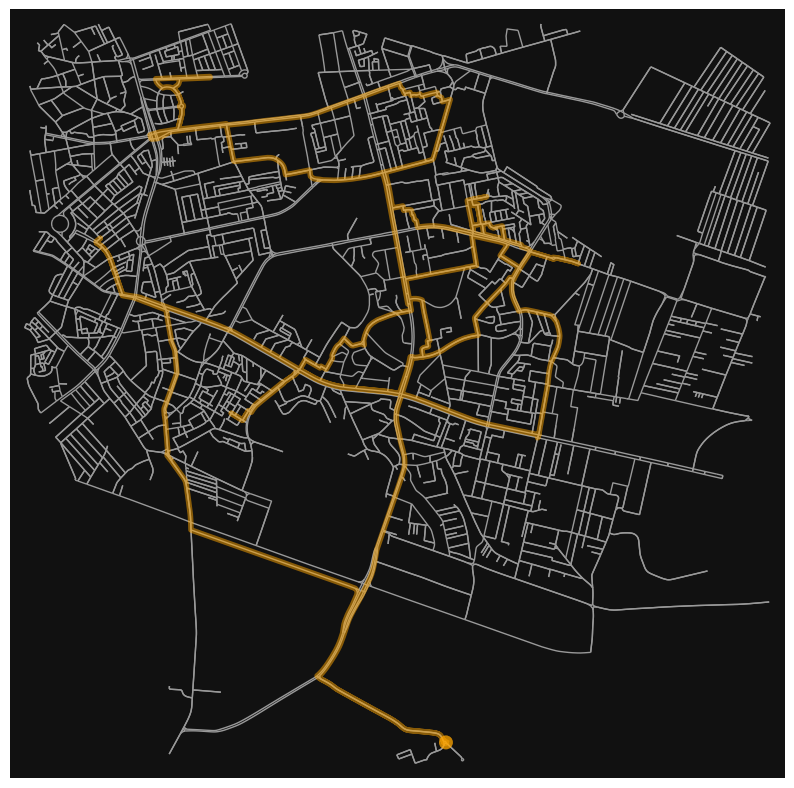

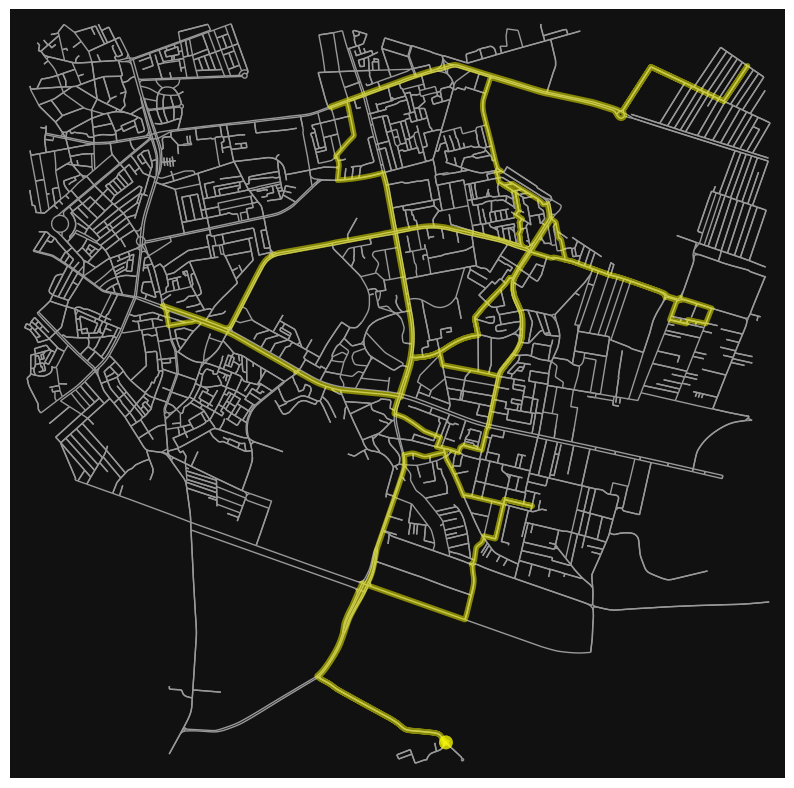

In [11]:
all_nodes = list(G.edges())

color_names = [
    'red', 'orange', 'yellow', 'green', 'blue',
    'indigo', 'violet', 'purple', 'pink', 'brown',
    'maroon', 'cyan', 'teal', 'lime', 'olive',
    'navy', 'gray', 'black', 'white', 'silver'
]

number_of_couriers = 3
number_of_destinatios_per_courier = 10
paths = []
colors = []

for i in range(0, number_of_couriers):
  paths.append(findBestWayForCourier(G, random.sample(all_nodes, number_of_destinatios_per_courier), HQ_COURIER))
  colors.append(color_names[i])

# Create a folium map centered around the HQ_COURIER
map_center = HQ_COURIER # Reversing the order to (latitude, longitude)
mymap = folium.Map(location=map_center, zoom_start=13)

# Plot the graph on the map
folium.Marker(location=HQ_COURIER[::-1], popup='HQ_COURIER', icon=folium.Icon(color='green')).add_to(mymap)

# Plot the routes and points for each courier
for i in range(number_of_couriers):
    route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in paths[i]]
    folium.PolyLine(locations=route_coords, color=colors[i], weight=5, opacity=0.7).add_to(mymap)

    for node in paths[i]:
        folium.Marker(
            location=(G.nodes[node]['y'], G.nodes[node]['x']),
            popup=f'Courier {i + 1} Point',
            icon=folium.Icon(color=colors[i], icon='circle', prefix='fa')
        ).add_to(mymap)

# Save the map as an HTML file or display it
mymap.save('couriers_map.html')

# Plot the graph with the routes highlighted in colors and display the plot
ox.plot_graph_routes(
    G,
    routes=paths,
    route_colors=colors,
    node_size=0,
    figsize=(10, 10)
)

for i in range(0, number_of_couriers):
  fig, ax = ox.plot_graph_route(G, paths[i], route_color=colors[i], node_size=0, figsize=(10, 10))
  # Add points for each edge in paths[i]
  path_points = [(G.nodes[node]['x'], G.nodes[node]['y']) for node in paths[i]]
  x, y = zip(*path_points)
  ax.scatter(x, y, color=colors[i], label=f'Courier {i + 1} Points', marker='o', s=50)

  # Display the legend
  ax.legend()
  plt.show()
